In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv(r"D:\Power bi\Time Series\Grocery-Store-Sales-Time-Series-Dataset.csv", skiprows=7, parse_dates=True)
data.head()

,Period,Value
0,Jan-21,63473.0
1,Feb-21,57967.0
2,Mar-21,63609.0
3,Apr-21,62593.0
4,May-21,66993.0


In [3]:
data["Period"] = pd.to_datetime(data["Period"], format="%b-%y")

In [4]:
data.head()

,Period,Value
0,2021-01-01,63473.0
1,2021-02-01,57967.0
2,2021-03-01,63609.0
3,2021-04-01,62593.0
4,2021-05-01,66993.0


In [5]:
data.dropna(inplace=True)

In [6]:
data.set_index("Period", inplace=True)

In [7]:
data.shape

(51, 1)

In [8]:
data.head()

,Value
Period,
2021-01-01,63473.0
2021-02-01,57967.0
2021-03-01,63609.0
2021-04-01,62593.0
2021-05-01,66993.0


In [9]:
data.tail()

,Value
Period,
2024-11-01,76232.0
2024-12-01,78601.0
2025-01-01,76065.0
2025-02-01,69314.0
2025-03-01,75275.0


Checking stationarity

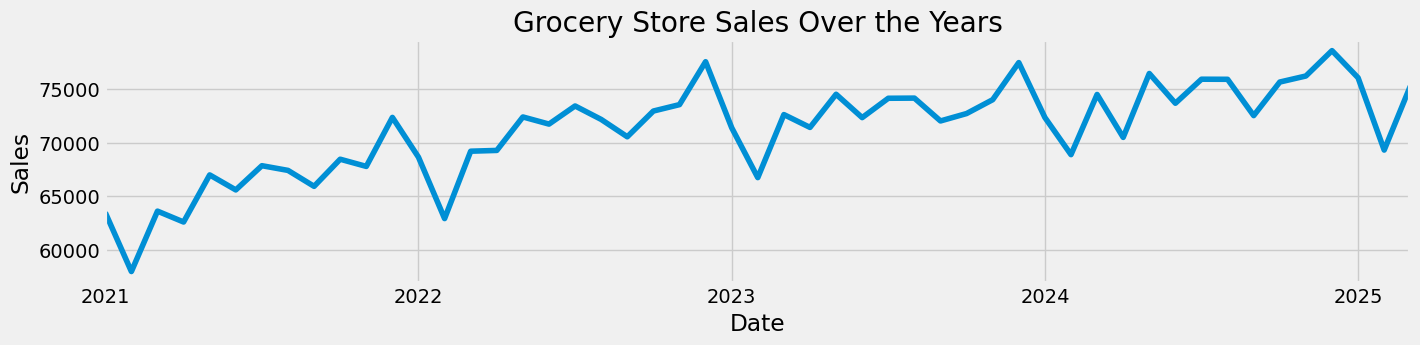

In [10]:
plt.figure(figsize=(15,3))
data['Value'].plot()
plt.title("Grocery Store Sales Over the Years")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

this is not stationarity

let's make it stationarity

so we are taking 1st level of differencing

In [11]:
df1 = data.diff()
df1.dropna(inplace=True)

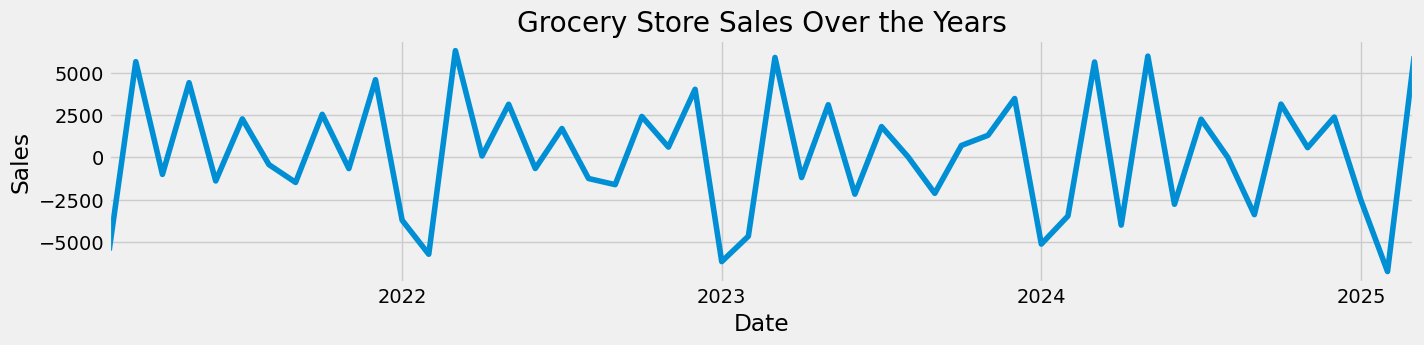

In [12]:
plt.figure(figsize=(15,3))
df1['Value'].plot()
plt.title("Grocery Store Sales Over the Years")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

Series is Stationary after taking 1st level of differencing.

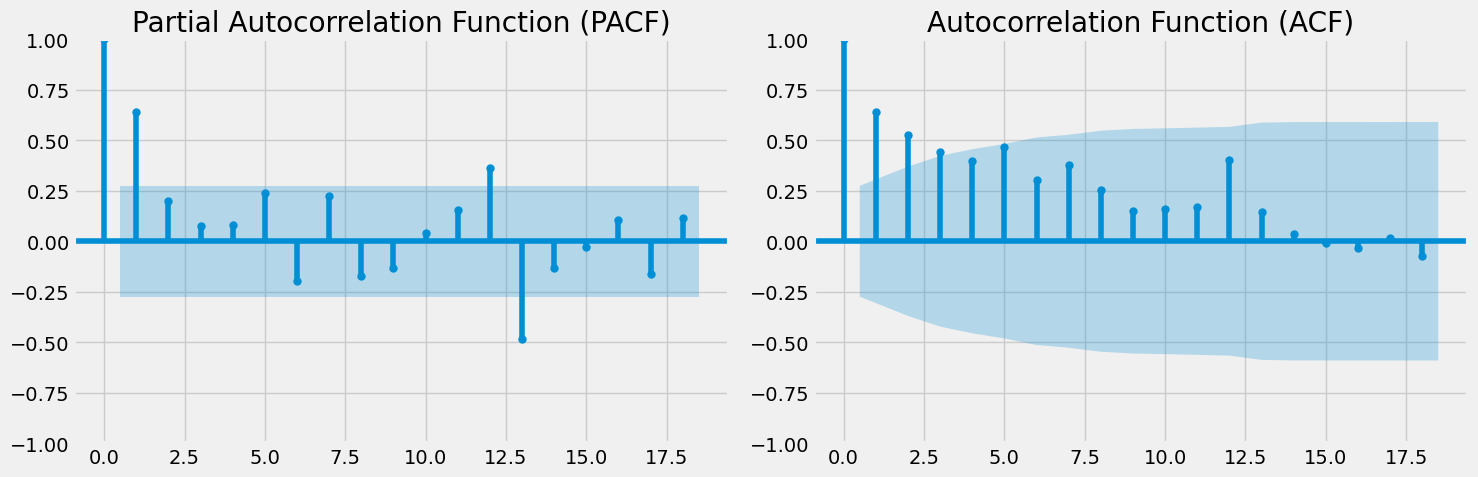

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# create a 1-row, 2-column subplot
fig, ax = plt.subplots(1,2, figsize=(15,5))

plot_pacf(data['Value'], ax=ax[0])
ax[0].set_title("Partial Autocorrelation Function (PACF)")

plot_acf(data['Value'], ax=ax[1])
ax[1].set_title("Autocorrelation Function (ACF)")

plt.tight_layout()
plt.show()

Decide p (from PACF) PACF tells AR order and Decide q (from ACF) ACF tells MA order

means p = 1, d = 1, q = 1, order=(p,d,q) = (1,1,1)

In [14]:
# slitting the data into train and test sets
'''train = data[:int(0.8*(len(data)))]
test = data[int(0.8*(len(data))):]'''

train = data[:-12]
test = data[-12:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (39, 1)
Test shape: (12, 1)


order=(1,1,1)

In [15]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(1,1,1))
model = model.fit()

c:\Users\LENOVO\anaconda3\envs\timeseries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\anaconda3\envs\timeseries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\anaconda3\envs\timeseries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   39
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -363.220
Date:                Fri, 09 Jan 2026   AIC                            732.439
Time:                        14:07:46   BIC                            737.352
Sample:                    01-01-2021   HQIC                           734.187
                         - 03-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.022     45.581      0.000       0.957       1.043
ma.L1         -0.9998      0.324     -3.086      0.002      -1.635      -0.365
sigma2      1.174e+07   2.96e-08   3.97e+14      0.0

In [17]:
# Forcating for next 12 months

#n_forecast = len(test)

n_forecast = 12

predict = model.predict(start=len(train), end=len(train)+n_forecast-1)

predict.rename("Predicted", inplace=True)

predict

2024-04-01    74709.478691
2024-05-01    74912.955835
2024-06-01    75116.431432
2024-07-01    75319.905482
2024-08-01    75523.377986
2024-09-01    75726.848942
2024-10-01    75930.318353
2024-11-01    76133.786216
2024-12-01    76337.252533
2025-01-01    76540.717303
2025-02-01    76744.180526
2025-03-01    76947.642203
Freq: MS, Name: Predicted, dtype: float64

In [18]:
pred_df = pd.DataFrame(predict)
pred_df.columns = ['Predicted Sales']
pred_df['Predicted Sales'] = round(pred_df['Predicted Sales'], 0)
pred_df

,Predicted Sales
2024-04-01,74709.0
2024-05-01,74913.0
2024-06-01,75116.0
2024-07-01,75320.0
2024-08-01,75523.0
2024-09-01,75727.0
2024-10-01,75930.0
2024-11-01,76134.0
2024-12-01,76337.0
2025-01-01,76541.0


In [19]:
actual_vs_predicted = pd.concat([test, pred_df], axis=1)

actual_vs_predicted['error'] = actual_vs_predicted['Value'] - actual_vs_predicted['Predicted Sales']

actual_vs_predicted.rename(columns={'Value':'Actual Sales'}, inplace=True)

actual_vs_predicted

,Actual Sales,Predicted Sales,error
2024-04-01,70496.0,74709.0,-4213.0
2024-05-01,76465.0,74913.0,1552.0
2024-06-01,73686.0,75116.0,-1430.0
2024-07-01,75931.0,75320.0,611.0
2024-08-01,75923.0,75523.0,400.0
2024-09-01,72532.0,75727.0,-3195.0
2024-10-01,75667.0,75930.0,-263.0
2024-11-01,76232.0,76134.0,98.0
2024-12-01,78601.0,76337.0,2264.0
2025-01-01,76065.0,76541.0,-476.0


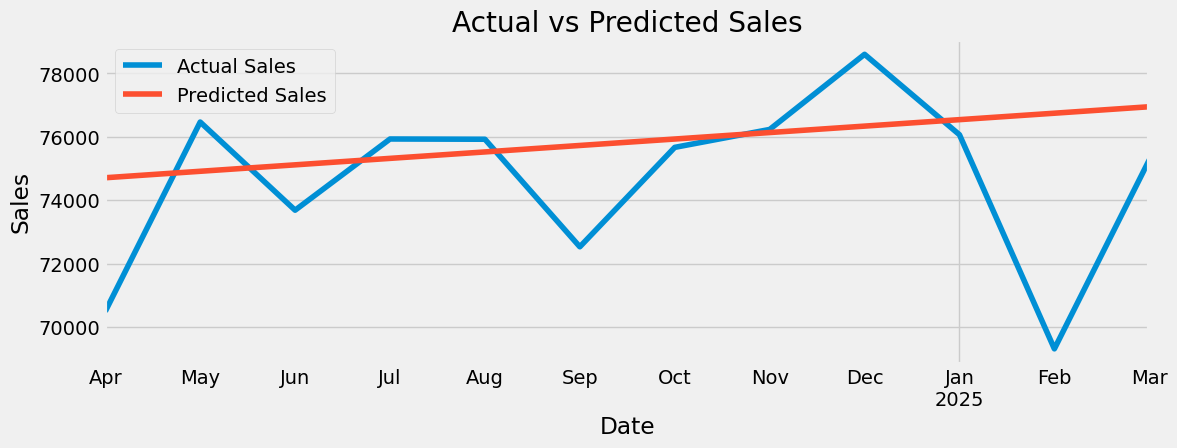

In [20]:
plt.figure(figsize=(12,4))
actual_vs_predicted['Actual Sales'].plot(label='Actual Sales')
actual_vs_predicted['Predicted Sales'].plot(label='Predicted Sales')
plt.title("Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

the data follow seasonality

ARIMA model cant handle the seasonality

so now we use SARIMAX

Find optimal values of non seasonal and seasonal order with auto_arima function

In [21]:
from pmdarima import auto_arima
auto_arima_result = auto_arima(train, seasonal=True, m=12)

In [22]:
print(auto_arima_result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   39
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -212.937
Date:                              Fri, 09 Jan 2026   AIC                            431.875
Time:                                      14:07:58   BIC                            435.649
Sample:                                  01-01-2021   HQIC                           432.962
                                       - 03-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5061      2.246     -0.225      0.822      -4.909       3.896
ma.S.L12       0.58

In [23]:
auto_arima_result.order, auto_arima_result.seasonal_order

((0, 1, 0), (1, 1, 1, 12))

- Non-seasonal part (p,d,q) = (0, 1, 0)
- Seasonal part (period = 12) (p, d, q) = (1, 1, 1, 12)

# Building SARIMAX Model on Training Data

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax_model = SARIMAX(train, order=auto_arima_result.order, seasonal_order=auto_arima_result.seasonal_order)
model_fit = sarimax_model.fit()

c:\Users\LENOVO\anaconda3\envs\timeseries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\anaconda3\envs\timeseries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\anaconda3\envs\timeseries\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [25]:
n_forecast = 12

pred_value = model_fit.predict(start=len(train), end=len(train)+n_forecast-1)

pred_value.rename("Predicted", inplace=True)

pred_df = pd.DataFrame(pred_value)

pred_df['Predicted'] = round(pred_df['Predicted'], 0)

pred_df

,Predicted
2024-04-01,73143.0
2024-05-01,76347.0
2024-06-01,73994.0
2024-07-01,75861.0
2024-08-01,76011.0
2024-09-01,73825.0
2024-10-01,74415.0
2024-11-01,75698.0
2024-12-01,79199.0
2025-01-01,73506.0


In [26]:
actual_vs_predicted = pd.concat([test, pred_df], axis=1)

actual_vs_predicted['error'] = actual_vs_predicted['Value'] - actual_vs_predicted['Predicted']

actual_vs_predicted.rename(columns={'Value':'Actual Sales'}, inplace=True)

actual_vs_predicted.rename(columns={'Predicted': 'Predicted Sales'}, inplace=True)

actual_vs_predicted

,Actual Sales,Predicted Sales,error
2024-04-01,70496.0,73143.0,-2647.0
2024-05-01,76465.0,76347.0,118.0
2024-06-01,73686.0,73994.0,-308.0
2024-07-01,75931.0,75861.0,70.0
2024-08-01,75923.0,76011.0,-88.0
2024-09-01,72532.0,73825.0,-1293.0
2024-10-01,75667.0,74415.0,1252.0
2024-11-01,76232.0,75698.0,534.0
2024-12-01,78601.0,79199.0,-598.0
2025-01-01,76065.0,73506.0,2559.0


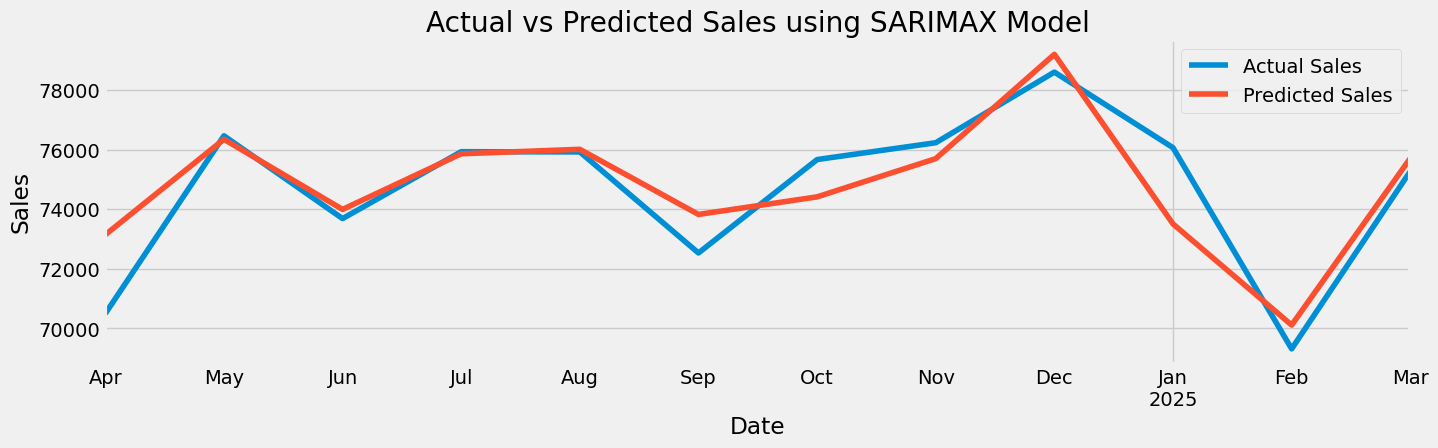

In [27]:
plt.figure(figsize=(15, 4))
actual_vs_predicted['Actual Sales'].plot(label='Actual Sales')
actual_vs_predicted['Predicted Sales'].plot(label='Predicted Sales')
plt.title("Actual vs Predicted Sales using SARIMAX Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [28]:
auto_arima_result = auto_arima(data, seasonal=True, m=12)

In [29]:
print(auto_arima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   51
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -325.575
Date:                            Fri, 09 Jan 2026   AIC                            657.151
Time:                                    14:08:03   BIC                            662.064
Sample:                                01-01-2021   HQIC                           658.899
                                     - 03-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0399      0.134      0.297      0.767      -0.223       0.303
ar.S.L24      -0.0585      0.058   

In [30]:
model_sarimax = SARIMAX(data, order=auto_arima_result.order, seasonal_order=auto_arima_result.seasonal_order)

c:\Users\LENOVO\anaconda3\envs\timeseries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\anaconda3\envs\timeseries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [31]:
model_fit = sarimax_model.fit()

c:\Users\LENOVO\anaconda3\envs\timeseries\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [32]:
n_forecast = 12

pred_value = model_fit.predict(start=len(data), end=len(data)+n_forecast-1)

pred_value.rename("Predicted", inplace=True)

pred_df = pd.DataFrame(pred_value)

pred_df['Predicted'] = round(pred_df['Predicted'], 0)

pred_df

,Predicted
2025-04-01,74430.0
2025-05-01,77580.0
2025-06-01,75314.0
2025-07-01,77151.0
2025-08-01,77232.0
2025-09-01,75073.0
2025-10-01,75715.0
2025-11-01,77003.0
2025-12-01,80486.0
2026-01-01,75078.0


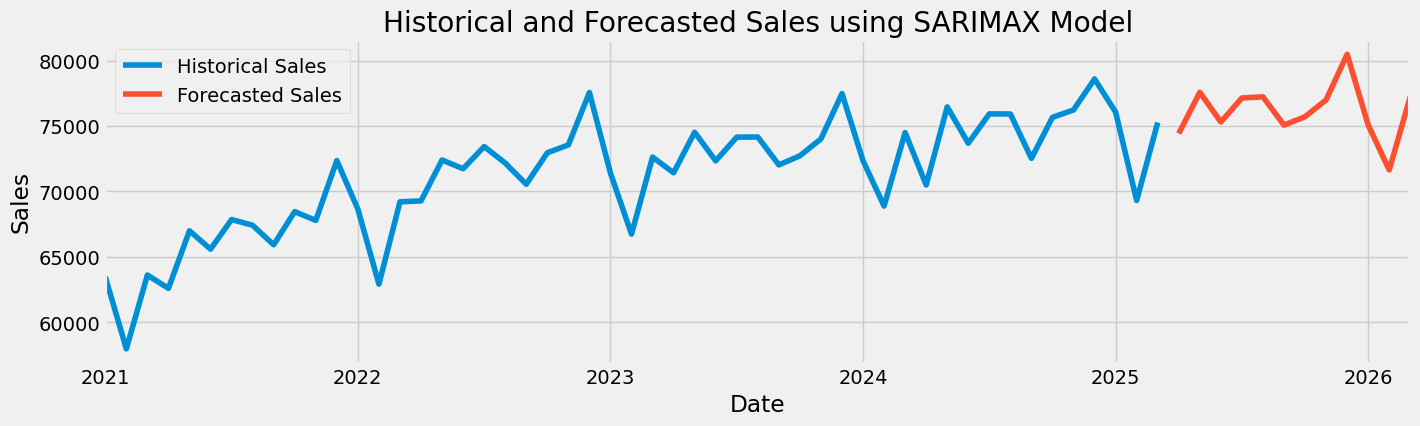

In [33]:
plt.figure(figsize=(15,4))
data['Value'].plot(label='Historical Sales')
pred_df['Predicted'].plot(label='Forecasted Sales')
plt.title("Historical and Forecasted Sales using SARIMAX Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()